## **Problema**


Este problema de rutas de reparación de cajeros automaticos, es un problema de optimización combinatoria y de programación de entero qué pregunta "¿Cuál es el conjunto óptimo de rutas para un grupo de tecnicos que debe satisfacer las reparaciones de un conjunto dado de cajeros automaticos?". Es una generalización del conocido Problema del Viajante (TSP). 

Fuente: [Wikipedia | Vehicule Routing Problem](https://es.wikipedia.org/wiki/Problema_de_enrutamiento_de_veh%C3%ADculos)

Los trayectos de los tecnicos, descritos utilizando un grafo donde los arcos son las carreteras y los vértices representan la localización de los cajeros automaticos y de las casas de cada tecnico.


# *Librerias Necesarias para la ejecución*

In [14]:
!pip install pandas
!pip install docplex
!pip install numpy
!pip install networkx
!pip install docloud
!pip install sklearn
!pip install folium
!pip install matplotlib

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --

## Insercion de Datos

In [3]:
import pandas as pd
from docplex.mp.model import Model
import numpy as np
import networkx as nx
from docloud.job import JobClient
from sklearn.cluster import KMeans
import os
from os.path import dirname, abspath, join
#el directorio tiene que ser el mismo para el archivo de entrada como para el modelo de Jupyter
#di = dirname(abspath(''))
di='/Users/cmsocj/IBM/ILOG/CPLEX_Studio128/workspace/ATM/'
df=pd.read_excel(di+'Inventario Disp ATM.xlsx',sheet_name='Data2') #data para el modelo
#FAVOR DE REVISAR LAS COORDENADAS, YA QUE SE SALEN DE LOS LIMITES DE LA CIUDAD DE BOGOTÁ
# filtro solo para Bogotá agregando .5 grad=55.6625kms
bogota='LATITUD_Y<=4.79 and LATITUD_Y>=4.461061 and LONGITUD_X>=-74.20 and LONGITUD_X<=-73.993114'
#bogota_50mas='LATITUD_Y<=5.335479 and LATITUD_Y>=3.961061 and LONGITUD_X>=-74.723175 and LONGITUD_X<=-73.493114'
centroides=pd.DataFrame.from_dict({'TECNICO DE SERVICIO':df.groupby(by='TECNICO DE SERVICIO',as_index=False)['LONGITUD_X','LATITUD_Y'].first()['TECNICO DE SERVICIO'].tolist()})
df=df.query(bogota).reset_index(drop=True)
#Parametros previos
pos2dis=111.325 #equivalencia de grados de latitud o longitud en distancia [grados/kms]
vel_urb=24 #velocidad pormedio [kms/hrs]
vel_interurb=26 #velocidad pormedio [kms/hrs]
distan_max=100 #kms es la distancia maxima en la ciudad de bogota 
Tiempo_max=10
n,m=len(centroides),len(df)
kmeans=KMeans(n_clusters=n, random_state=0).fit(df[['LONGITUD_X','LATITUD_Y']])
centroides["LONGITUD_X"]=kmeans.cluster_centers_[:,0].tolist()
centroides["LATITUD_Y"]=kmeans.cluster_centers_[:,1].tolist()
centroides["NumTecnico"]=list(range(-n,0))
centroides["colores"]=['red','blue','green','purple','orange','brown','darkred','darkblue','darkgreen'] 

## **Parametros del problema**

Los parametros del problema que ocupamos, fueron:

    -La equivalencia de grados de latitud o longitud en distancia en el ecuador es de 111.325 [grados/kms].
    -La velocidad urbana pormedio en Bogotá es de 24 [kms/hrs].
    -La distancia maxima en Bogotá es de 100 [kms].
    -Tiempo maximo de trabajo por tecnico es de 10 [hrs].
    -La ubicacion de las casas de los tecnicos no es conocida, ocupamos el algoritmo de kmeans para ubicarlas.

In [4]:
print("-La cantidad de cajeros en Bogotá es de "+str(m))
print("-La cantidad de tecnicos en Bogotá es de "+str(n))

-La cantidad de cajeros en Bogotá es de 85
-La cantidad de tecnicos en Bogotá es de 9


In [5]:
import folium as fl
colores=['red','blue','green','purple','orange','brown','darkred','darkblue','darkgreen','pink']
mapa=fl.Map(location=[df["LATITUD_Y"].mean(),df["LONGITUD_X"].mean()])
fg=fl.FeatureGroup(name="Cajeros")
for k in range(m):
    fg.add_child(fl.Marker(location=[df["LATITUD_Y"][k],df["LONGITUD_X"][k]],
                           popup=fl.Popup("ATM {0}".format(df["CODIGO"][k])),
                           icon=fl.Icon(color="white",icon_color="black",icon="credit-card"),
                          draggable=True))
    mapa.add_child(fg)
fg1=fl.FeatureGroup(name="Tecnicos")
for k in range(n):
    fg.add_child(fl.Marker(location=[centroides["LATITUD_Y"][k],centroides["LONGITUD_X"][k]],
                           popup=fl.Popup("Tec. {0}".format(centroides["TECNICO DE SERVICIO"][k])),
                           icon=fl.Icon(color=centroides["colores"][k],icon_color="white",icon="home"),
                          draggable=True))
    mapa.add_child(fg1)
mapa

In [6]:
tc=df['TIEMPO DE MANTENCION [hrs]'].values
cajeros=list(range(m))
tecnicos=centroides["NumTecnico"].tolist()
nodos=cajeros+tecnicos#los nodos centroides son asignados negativos
tecnicajeros={(i,j) for i in cajeros for j in tecnicos}
arcos={(i,j,p) for i in cajeros for j in cajeros for p in tecnicos if i!=j}
t_caj2caj={(i,j):(np.abs(df["LONGITUD_X"][i]-df["LONGITUD_X"][j])+np.abs(df["LATITUD_Y"][i]-df["LATITUD_Y"][j]))*pos2dis/(vel_urb+vel_interurb*(np.abs(df["LONGITUD_X"][i]-df["LONGITUD_X"][j])+np.abs(df["LATITUD_Y"][i]-df["LATITUD_Y"][j])>distan_max)) for i in cajeros for j in cajeros if i!=j}
for p in tecnicos:
    centro=centroides[centroides['NumTecnico']==p][["LONGITUD_X","LATITUD_Y"]].values[0]
    t_caj2caj.update({(i,p):(np.abs(df["LONGITUD_X"][i]-centro[0])+np.abs(df["LATITUD_Y"][i]-centro[1]))*pos2dis/(vel_urb+vel_interurb*(np.abs(df["LONGITUD_X"][i]-centro[0])+np.abs(df["LATITUD_Y"][i]-centro[1])>distan_max)) for i in cajeros})
    t_caj2caj.update({(p,i):(np.abs(df["LONGITUD_X"][i]-centro[0])+np.abs(df["LATITUD_Y"][i]-centro[1]))*pos2dis/(vel_urb+vel_interurb*(np.abs(df["LONGITUD_X"][i]-centro[0])+np.abs(df["LATITUD_Y"][i]-centro[1])>distan_max)) for i in cajeros})
    arcos.update({(i,p,p) for i in cajeros})
    arcos.update({(p,i,p) for i in cajeros})
    tecnicajeros.update({(p,p)})
client = JobClient("https://api-oaas.docloud.ibmcloud.com/job_manager/rest/v1/","api_a2d08d4c-29b4-414c-8606-08a58626a739")
client.delete_all_jobs()
L=sum(t_caj2caj[(i,j)] for i in nodos for j in nodos if (i!=j and i>=0 and j>=0) or (i<0 and j>=0) or (j<0 and i>=0))
M=int(np.ceil(max(L-t_caj2caj[k,i]-t_caj2caj[j,k]+t_caj2caj[i,j] for i,j,k in arcos if i>=0 and j>=0)))
mdl=Model('MDVRP')
x=mdl.binary_var_dict(arcos,name='x')
e=mdl.continuous_var(lb=0,name='e')
u=mdl.continuous_var_dict(tecnicajeros,lb=0,name='u')
mdl.minimize(mdl.sum(t_caj2caj[i,j]*x[i,j,p] for i,j,p in arcos)+e)
mdl.add_constraints(mdl.sum(x[i,j,p] for j in list(set(nodos)-{i}) for p in tecnicos if j>=0 or j==p)==1 for i in cajeros)
mdl.add_constraints(mdl.sum(x[i,j,p] for i in list(set(nodos)-{j}) for p in tecnicos if i>=0 or i==p)==1 for j in cajeros)
mdl.add_constraints(mdl.sum(x[i,j,k]-x[j,i,k] for i in list(set(nodos)-{j}) if i>=0 or i==k)==0 for j,k in tecnicajeros)
## cotas de horas de trabajo pormedio por tecnico
mdl.add_constraints(0>=mdl.sum((tc[j]+(i>=0)*t_caj2caj[i,j]-Tiempo_max*(i==p))*x[i,j,p] for i in nodos for j in cajeros if (i!=j and i>=0) or i==p) for p in tecnicos)
mdl.add_constraints(0<=mdl.sum((tc[j]+(i>=0)*t_caj2caj[i,j]-8*(i==p))*x[i,j,p] for i in nodos for j in cajeros if (i!=j and i>=0) or i==p) for p in tecnicos)
mdl.add_constraints(u[i,k]+tc[j]+t_caj2caj[i,j]+M*x[i,j,k]<=M+u[j,k] for i,j,k in arcos if j>=0 and i>=0)
mdl.add_constraints(tc[j]<=mdl.sum(u[j,k] for k in tecnicos) for j in cajeros)
mdl.add_constraints(mdl.sum(u[j,k] for k in tecnicos)<=mdl.sum(Tiempo_max*x[i,j,k] for i,k in tecnicajeros if i!=j) for j in cajeros)
mdl.add_constraints(mdl.sum(x[s,p,p] for s in cajeros)<=e  for p in tecnicos)
mdl.add_constraints(mdl.sum(x[s,p,p] for s in cajeros)>=1  for p in tecnicos)
#mdl.parameters.mip.strategy.dive=3
#mdl.parameters.mip.strategy.lbheur=1
#mdl.parameters.mip.strategy.rinsheur=500
mdl.context.cplex_parameters.threads=20
mdl.context.cplex_parameters.emphasis.memory=1
mdl.context.cplex_parameters.emphasis.mip=2
mdl.parameters.mip.tolerances.mipgap.set(0.1)
mdl.parameters.timelimit=1500 #tiempo minimo para encontrar una solucion factible entera, es 6 min (360 seg)
solucion=mdl.solve(url="https://api-oaas.docloud.ibmcloud.com/job_manager/rest/v1/",key="api_a2d08d4c-29b4-414c-8606-08a58626a739",log_output=True)
#Arcos optimos:
L=np.array([[k[0],k[1],k[2]] for k in arcos if x[k].solution_value>0.9])
V={}
for k in np.unique(L[:,2]):
    V.update({k:list(set(np.unique(L[L[:,2]==k,:1].reshape(L[L[:,2]==k,:1].size)).tolist())-{k})})
        

[2019-05-13T20:20:00Z, INFO] CPLEX version 12080000
[2019-05-13T20:20:00Z, INFO] Parameter file:
[2019-05-13T20:20:00Z, INFO] # -- This content is generated by DOcplex
[2019-05-13T20:20:00Z, INFO] CPLEX Parameter File Version 12.8.0.0
[2019-05-13T20:20:00Z, INFO] CPX_PARAM_THREADS                20
[2019-05-13T20:20:00Z, INFO] CPX_PARAM_TILIM                  1500.00000000000000
[2019-05-13T20:20:00Z, INFO] CPX_PARAM_MEMORYEMPHASIS         1
[2019-05-13T20:20:00Z, INFO] CPX_PARAM_MIPEMPHASIS            2
[2019-05-13T20:20:00Z, INFO] CPX_PARAM_EPGAP                  0.10000000000000
[2019-05-13T20:20:00Z, INFO] # --- end of generated prm data ---
[2019-05-13T20:20:00Z, WARN] Changed parameter CPX_PARAM_THREADS from 20 to 10
[2019-05-13T20:20:00Z, INFO] Param[1,039] = 1500
[2019-05-13T20:20:00Z, INFO] Param[1,067] = 10
[2019-05-13T20:20:00Z, INFO] Param[1,082] = 1
[2019-05-13T20:20:00Z, INFO] Param[1,130] = utf-8
[2019-05-13T20:20:00Z, INFO] Param[1,132] = -1
[2019-05-13T20:20:00Z, INFO]

[2019-05-13T20:21:52Z, INFO]    1990  1729    infeasible                            5.0694   199802
[2019-05-13T20:21:55Z, INFO]    2093  1697       13.3986    93                      5.0694   197123
[2019-05-13T20:21:58Z, INFO]    2190  1917        8.0311   125                      5.0694   223187
[2019-05-13T20:21:58Z, INFO] Elapsed time = 117.47 sec. (46950.92 ticks, tree = 1113.09 MB, solutions = 0)
[2019-05-13T20:22:00Z, INFO]    2281  1874       14.0762    85                      5.0694   217288
[2019-05-13T20:22:02Z, INFO]    2390  2008        9.5956   106                      5.0694   234957
[2019-05-13T20:22:05Z, INFO]    2488  2084       11.7494    97                      5.0694   240493
[2019-05-13T20:22:07Z, INFO]    2562  2104        9.6323   116                      5.0694   242848
[2019-05-13T20:22:10Z, INFO]    2643  2297        6.4643   133                      5.0694   264079
[2019-05-13T20:22:13Z, INFO]    2740  2324       10.3270   109                      5.0694   

[2019-05-13T20:27:40Z, INFO]    4668   902        6.2929   168       37.7076        5.0794   454615   86.53%
[2019-05-13T20:27:48Z, INFO]    4761   946        6.1745   176       37.7076        5.0794   461029   86.53%
[2019-05-13T20:27:56Z, INFO]    4856  1008        5.6955   202       37.7076        5.0794   466010   86.53%
[2019-05-13T20:28:04Z, INFO]    4937  1142        6.5676   156       37.7076        5.0794   482721   86.53%
[2019-05-13T20:28:12Z, INFO]    5035  1345        6.1240   177       37.7076        5.0794   498970   86.53%
[2019-05-13T20:28:19Z, INFO]    5124  1345        7.0892   167       37.7076        5.0794   499118   86.53%
[2019-05-13T20:28:19Z, INFO] Elapsed time = 498.51 sec. (248461.50 ticks, tree = 51.99 MB, solutions = 2)
[2019-05-13T20:28:27Z, INFO]    5189  1491        5.9190   176       37.7076        5.0794   515493   86.53%
[2019-05-13T20:28:36Z, INFO]    5258  1502        6.1290   180       37.7076        5.0794   516311   86.53%
[2019-05-13T20:28:47Z,

[2019-05-13T20:35:38Z, INFO]    8517  4552        8.8735   169       27.8854        5.0794   894260   81.78%
[2019-05-13T20:35:46Z, INFO]    8573  4588        6.5269   171       27.8854        5.0794   906195   81.78%
[2019-05-13T20:35:54Z, INFO]    8671  4605        6.8151   185       27.8854        5.0794   908031   81.78%
[2019-05-13T20:36:03Z, INFO]    8719  4762        6.8249   197       27.8854        5.0794   938151   81.78%
[2019-05-13T20:36:11Z, INFO]    8809  4805        5.2265   196       27.8854        5.0794   945635   81.78%
[2019-05-13T20:36:19Z, INFO]    8938  4824        5.3718   213       27.8854        5.0794   945932   81.78%
[2019-05-13T20:36:28Z, INFO]    9036  4982        6.8549   186       27.8854        5.0794   965820   81.78%
[2019-05-13T20:36:28Z, INFO] Elapsed time = 987.26 sec. (481781.60 ticks, tree = 797.60 MB, solutions = 41)
[2019-05-13T20:36:36Z, INFO]    9101  5025        5.3795   209       27.8854        5.0794   968874   81.78%
[2019-05-13T20:36:44

Despues de aplicar el modelo de optimizacion de rutas para los tecnicos podemos ver que cada cajero tiene una ruta optima para el tecnico.

In [57]:
mapa=fl.Map(location=[df["LATITUD_Y"].mean(),df["LONGITUD_X"].mean()])
for k in range(n):
    p=centroides["NumTecnico"][k]
    fg1=fl.FeatureGroup(name=centroides["TECNICO DE SERVICIO"][k])
    for i,j in L[L[:,2]==p,:2]:
        if i>=0:
            y0,x0=df["LATITUD_Y"][i],df["LONGITUD_X"][i]
            cod0=df["CODIGO"][i]
        else:
            y0,x0=centroides[centroides["NumTecnico"]==i]["LATITUD_Y"].values[0],centroides[centroides["NumTecnico"]==i]["LONGITUD_X"].values[0]
            cod0="Tec. "+centroides[centroides["NumTecnico"]==i]["TECNICO DE SERVICIO"].values[0]
        if j>=0:
            y1,x1=df["LATITUD_Y"][j],df["LONGITUD_X"][j]
            cod1=df["CODIGO"][j]
        else:
            y1,x1=centroides[centroides["NumTecnico"]==j]["LATITUD_Y"].values[0],centroides[centroides["NumTecnico"]==j]["LONGITUD_X"].values[0]
            cod1="Tec. "+centroides[centroides["NumTecnico"]==j]["TECNICO DE SERVICIO"].values[0]
        lin=fl.PolyLine(locations=[[y0,x0],[y1,x1]],color=centroides[centroides["NumTecnico"]==p]["colores"].values[0],
                        weight=1.5,opacity=1,
                        popup=fl.Popup("${0}-{1}={2}[hrs]$".format(cod0,cod1,t_caj2caj[i,j])))
        fg1.add_child(lin)
        long_diff=np.radians(x1-x0)    
        lat1=np.radians(y0)
        lat2=np.radians(y1)    
        x=np.sin(long_diff)*np.cos(lat2)
        y=(np.cos(lat1)*np.sin(lat2)-(np.sin(lat1)*np.cos(lat2)*np.cos(long_diff)))
        rotation=np.degrees(np.arctan2(x, y))%360 -90
        arr=fl.RegularPolygonMarker(location=[(y0+y1)/2,(x0+x1)/2],fill_color=centroides["colores"][k], 
                                number_of_sides=0,radius=6,rotation=rotation)
        fg1.add_child(arr)
        
    fg1.add_child(fl.Marker(location=[centroides["LATITUD_Y"][k],centroides["LONGITUD_X"][k]],
                           popup=fl.Popup("Tec. {0}".format(centroides["TECNICO DE SERVICIO"][k])),
                           icon=fl.Icon(color=centroides["colores"][k],icon_color="white",icon="home"),
                           draggable=True))
    for h in V[centroides["NumTecnico"][k]]:
        fg1.add_child(fl.Marker(location=[df["LATITUD_Y"][h],df["LONGITUD_X"][h]],
                               popup=fl.Popup("ATM {0}".format(df["CODIGO"][h])),
                               icon=fl.Icon(color=centroides["colores"][k],icon_color="white",icon="credit-card"),
                               draggable=True))
    mapa.add_child(fg1)
fl.LayerControl().add_to(mapa)
mapa
    

In [8]:
start=True
for p in tecnicos:
    centro=centroides[centroides['NumTecnico']==p][["LONGITUD_X","LATITUD_Y"]].values[0]
    G = nx.Graph()
    for j in L[L[:,2]==p,:2]:
        G.add_edge(j[0],j[1])
    C=nx.cycle_basis(G,p) 
    A=list(set(L[L[:,2]==p,:2].reshape(L[L[:,2]==p,:2].size).tolist()))
    B=[]
    for k in range(len(C)):
        B+=C[k]
    A=list(set(A)-set(B))
    if len(A)>0:
        Y=L[L[:,2]==p,:2]
        G1=nx.DiGraph()
        for j in Y[np.any(np.isin(Y,A),axis=1)]:
            G1.add_edge(j[0],j[1])
        K=list(nx.simple_cycles(G1))
        for k in K:
            C+=[np.sort(k).tolist()[::-1]]
    for c in C:
        aux=np.array(c)
        aux=aux[np.array(c)>=0].tolist()
        dd=pd.DataFrame.from_dict({'Tecnico':[centroides[centroides['NumTecnico']==p]['TECNICO DE SERVICIO'].values[0]],
            "Camino":[tuple(df['CODIGO'][aux])],
            "tiempotrabajo":[sum(tc[aux])+sum(t_caj2caj[aux[k-1],aux[k]] for k in range(1,len(aux)) if len(aux)>=2)],
            "Tiempo de trayecto total":[t_caj2caj[p,aux[0]]+t_caj2caj[aux[-1],p]],
            "Tiempo de reparacion":[sum(tc[aux])],
            "Tiempo de trayecto entre cajeros":[sum(t_caj2caj[aux[k-1],aux[k]] for k in range(1,len(aux)) if len(aux)>=2)],
            "Cantidad de cajeros":[len(aux)]})
        if start:
            RT=dd
            start=False
        else:
            RT=RT.append(dd)
RT['Horas extras']=[max(k-8,0) for k in RT["tiempotrabajo"]]
RT['Tiempo reglamentario trabajado']=[min(k,8) for k in RT["tiempotrabajo"]]
RT=RT[['Tecnico',"Camino","Cantidad de cajeros","Tiempo de reparacion","Tiempo de trayecto entre cajeros",'Tiempo reglamentario trabajado','Horas extras',"Tiempo de trayecto total"]].sort_values(by=["Tecnico","Cantidad de cajeros"],ascending=[True,False])
RT['dias']=1 
RT['dias']=RT.groupby('Tecnico',as_index=False)['dias'].cumsum()
RT.reset_index(drop=True)

,Tecnico,Camino,Cantidad de cajeros,Tiempo de reparacion,Tiempo de trayecto entre cajeros,Tiempo reglamentario trabajado,Horas extras,Tiempo de trayecto total,dias
0,CRISTOBAL AGUADO RUIZ,"(3016, 2063, 6242, 7045)",4,8,1.250835,8.000000,1.250835,0.507191,1
1,DANIEL RICARDO ROA ROZO,"(K 2077, 6505, 452, 2066, 3656)",5,10,1.662291,8.000000,3.662291,0.509516,1
2,DANIEL RICARDO ROA ROZO,"(3681, 3066, 2487)",3,6,0.546719,6.546719,0.000000,0.906283,2
3,HAROL HERNEY TAPIA FLOREZ,"(3022, 447, 1545, 320, 509)",5,10,0.756013,8.000000,2.756013,0.502643,1
4,HAROL HERNEY TAPIA FLOREZ,"(2026, K 2080, 6711)",3,6,0.292841,6.292841,0.000000,0.196730,2
5,JEFERSON PEÑA BELTRAN,"(3047, 2779, 2461, K 2106, 2381)",5,10,0.515904,8.000000,2.515904,0.248391,1
6,JEFERSON PEÑA BELTRAN,"(572, 6390, 4714, 2426, 4299)",5,10,0.625532,8.000000,2.625532,0.279587,2
7,JEFERSON PEÑA BELTRAN,"(571, 4816)",2,4,0.045821,4.045821,0.000000,0.486339,3
8,JOSE EVERSENIO ARIAS GARZON,"(230, 3007, 2538, 1910, 465)",5,10,0.563460,8.000000,2.563460,0.868947,1
9,JOSE EVERSENIO ARIAS GARZON,"(598, 2052, 482)",3,6,0.685617,6.685617,0.000000,0.587042,2


In [9]:
RT.groupby('Tecnico',as_index=False).agg({"Cantidad de cajeros":{"Total":"sum","Promedio Diario":"mean","Dias trabajados":"count"},'Tiempo reglamentario trabajado':{'Total':"sum",'Promedio diario':"mean"},'Horas extras':{'Total':"sum",'Promedio diario':"mean"},"Tiempo de trayecto total":{'Total':"sum",'Promedio diario':"mean"}}).reset_index(drop=True)

/Users/cmsocj/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Tecnico Cantidad de cajeros                  \
                                                Total Promedio Diario   
0           CRISTOBAL AGUADO RUIZ                   4        4.000000   
1         DANIEL RICARDO ROA ROZO                   8        4.000000   
2       HAROL HERNEY TAPIA FLOREZ                   8        4.000000   
3           JEFERSON PEÑA BELTRAN                  12        4.000000   
4     JOSE EVERSENIO ARIAS GARZON                   8        4.000000   
5       JOSE RICARDO GARCIA BELLO                  12        4.000000   
6  JULIO ROBERTO CORDERO CASALLAS                  13        4.333333   
7        SERGIO COLLAZOS BAUTISTA                   9        4.500000   
8    VICTOR RAFAEL PADILLA PUELLO                  11        3.666667   

                  Tiempo reglamentario trabajado                 Horas extras  \
  Dias trabajados                          Total Promedio diario        Total   
0               1                       8.000000        8.000000     1.250835   
1               2                      14.546719        7.273360     3.662291   
2               2                      14.292841        7.146421     2.756013   
3               3                      20.045821        6.681940     5.141436   
4               2                      14.685617        7.342809     2.563460   
5               3                      22.230547        7.410182     3.410688   
6               3                      24.000000        8.000000     3.793082   
7               2                      16.000000        8.000000     3.726982   
8               3                      20.637487        6.879162     3.652045   

                  Tiempo de trayecto total                  
  Promedio diario                    Total Promedio diario  
0        1.250835                 0.507191        0.507191  
1        1.831146                 1.415799        0.707900  
2        1.378006                 0.699373        0.349686  
3        1.713812                 1.014318        0.338106  
4        1.281730                 1.455989        0.727994  
5        1.136896                 1.807796        0.602599  
6        1.264361                 1.474031        0.491344  
7        1.863491                 0.528860        0.264430  
8        1.217348                 1.586135        0.528712

([<matplotlib.axis.XTick at 0x2258c937b00>,
 <a list of 4 Text xticklabel objects>)

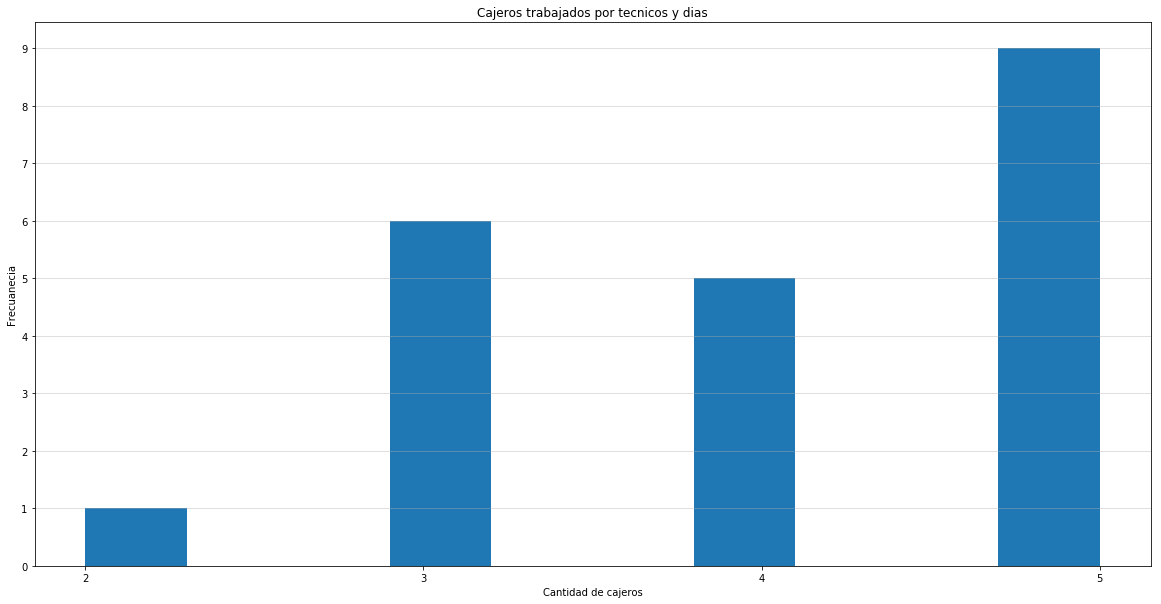

In [21]:
import matplotlib.pyplot as plt
RT["Cantidad de cajeros"].plot.hist(figsize=(20,10))
plt.title('Cajeros trabajados por tecnicos y dias')
plt.xlabel('Cantidad de cajeros')
plt.ylabel('Frecuanecia')
plt.grid(axis='y', alpha=.5)
plt.yticks(range(RT.groupby(["Cantidad de cajeros"]).count().values[:,1].max()+1))
plt.xticks(range(RT["Cantidad de cajeros"].values.min(),RT["Cantidad de cajeros"].values.max()+1))

In [56]:
A=RT["Camino"].astype(str).str.replace("(","").str.replace(")","").str.replace("'","").str.split(",",expand=True)
q,p=A.shape
A['dias']=RT['dias']
A['Tecnico']=RT['Tecnico']
start=True
for k in range(q):
    S=np.array([[A['dias'].iloc[k],A['Tecnico'].iloc[k],A[j].iloc[k]] for j in range(p) if A[j].iloc[k] is not None])
    if start:
        B=S
        start=False
    else:
        B=np.append(B,S,axis=0)
df1=pd.DataFrame.from_dict({"dias":B[:,0].astype(int).reshape(B.shape[0]).tolist()})
df1['Tecnico']=B[:,1].reshape(B.shape[0]).tolist()
df1['CODIGO']=B[:,2].reshape(B.shape[0]).tolist()
df1['CODIGO']=df1['CODIGO'].str.replace(" K","K")
DF=pd.merge(df,df1,on='CODIGO', how='inner')
df1['CODIGO']=pd.to_numeric(df1['CODIGO'],errors='coerse')
df1=df1.dropna()
df1['CODIGO']=df1['CODIGO'].astype(df['CODIGO'].dtypes)
DF1=pd.merge(df,df1,on='CODIGO', how='inner')
DF=pd.concat([DF1,DF])
DF['Fecha Mantenimiento Optima']=pd.to_datetime(DF['dias']-1, unit='D',origin=df['FECHA MANTENIMIENTO MAQUINA'].min())
DF.sort_values("Tecnico",ascending=True).reset_index(drop=True)

,CODIGO,TECNICO DE SERVICIO,TIPOLOGIA ATENCION FLM (TECNICO ATH),LONGITUD_X,LATITUD_Y,FECHA MANTENIMIENTO MAQUINA,TIEMPO DE MANTENCION [hrs],Ciudad de Bogotá [LATITUD_Y entre 4 y 5.29; LONGITUD_X entre -74.51 y -73.73],Cajero,Peso,dias,Tecnico,Fecha Mantenimiento Optima
0,2063,JULIO ROBERTO CORDERO CASALLAS,TIPO A,-74.085197,4.739714,2019-02-11,2,Este Cajero está en Bogotá,1,17,1,CRISTOBAL AGUADO RUIZ,2019-01-08
1,3016,HAROL HERNEY TAPIA FLOREZ,TIPO A,-74.065584,4.636450,2019-01-11,2,Este Cajero está en Bogotá,79,29,1,CRISTOBAL AGUADO RUIZ,2019-01-08
2,6242,HAROL HERNEY TAPIA FLOREZ,TIPO A,-74.074000,4.641660,2019-01-24,2,Este Cajero está en Bogotá,32,22,1,CRISTOBAL AGUADO RUIZ,2019-01-08
3,7045,HAROL HERNEY TAPIA FLOREZ,TIPO A,-74.058645,4.663837,2019-02-20,2,Este Cajero está en Bogotá,101,43,1,CRISTOBAL AGUADO RUIZ,2019-01-08
4,K 2077,VICTOR RAFAEL PADILLA PUELLO,TIPO A,-74.049965,4.684432,2019-01-22,2,Este Cajero está en Bogotá,113,94,1,DANIEL RICARDO ROA ROZO,2019-01-08
5,2066,DANIEL RICARDO ROA ROZO,TIPO A,-74.066385,4.632145,2019-01-18,2,Este Cajero está en Bogotá,2,61,1,DANIEL RICARDO ROA ROZO,2019-01-08
6,3681,JOSE EVERSENIO ARIAS GARZON,TIPO A,-74.030046,4.740218,2019-01-23,2,Este Cajero está en Bogotá,77,16,2,DANIEL RICARDO ROA ROZO,2019-01-09
7,452,JULIO ROBERTO CORDERO CASALLAS,TIPO A,-74.085034,4.737756,2019-02-08,2,Este Cajero está en Bogotá,8,85,1,DANIEL RICARDO ROA ROZO,2019-01-08
8,3066,VICTOR RAFAEL PADILLA PUELLO,TIPO A,-74.044411,4.682914,2019-01-22,2,Este Cajero está en Bogotá,81,33,2,DANIEL RICARDO ROA ROZO,2019-01-09
9,3656,JULIO ROBERTO CORDERO CASALLAS,TIPO A,-74.095681,4.748561,2019-01-23,2,Este Cajero está en Bogotá,64,23,1,DANIEL RICARDO ROA ROZO,2019-01-08


In [58]:
print("En la tabla anterior podemos ver que el trabajo que se realizo entre "+str(df['FECHA MANTENIMIENTO MAQUINA'].min())
      +" y "+str(df['FECHA MANTENIMIENTO MAQUINA'].max())+", el modelo de optimizacion de ruta dice que el todo este trabajo se pude realizar entre "
     +str(DF['Fecha Mantenimiento Optima'].min())+" y "+str(DF['Fecha Mantenimiento Optima'].max()))

En la tabla anterior podemos ver que el trabajo que se realizo entre 2019-01-08 00:00:00 y 2019-02-27 00:00:00, el modelo de optimizacion de ruta dice que el todo este trabajo se pude realizar entre 2019-01-08 00:00:00 y 2019-01-10 00:00:00


## Bibliografia:

1)https://sites.google.com/site/antoniopadillac/Home/pesosymedidas/meridianosyparalelos
2)https://es.wikipedia.org/wiki/Problema_de_enrutamiento_de_veh%C3%ADculos
3)http://repositorio.unicordoba.edu.co/bitstream/handle/123456789/627/Trabajo%20de%20grado.pdf?sequence=1
4)https://doi.org/10.1080/19427867.2016.1274468
5)https://doi.org/10.1016/S0377-2217(03)00377-1
6)https://doi.org/10.1016/0167-6377(91)90083-2
